# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.simplefilter('ignore') 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Загружаем исходную информацию по 3м регионам нефтедобычи.

In [2]:
r0 = pd.read_csv('/datasets/geo_data_0.csv')
r1 = pd.read_csv('/datasets/geo_data_1.csv')
r2 = pd.read_csv('/datasets/geo_data_2.csv')

Создал процедуру для изучения данных.

In [3]:
def data_exam(region):
    
    display(region.head())
    print()
    print("Наличие дубликатов:", region.duplicated().sum())
    print()
    print(region.describe())
    print()
    region.boxplot(column = 'product',figsize=(7,5))
    plt.title("Добыча по региону")
    plt.ylabel("тыс.баррелей")
    plt.show()
    
    region.info()
    print()
    print("Матрица корреляции")
    print(region.corr())
    df_plot = sns.heatmap(region.corr(), cmap="YlGnBu", annot=True)
    plt.title('Тепловая карта корреляции')
    plt.show()
         
    region.hist(figsize=(10, 12))
    print("Гистограммы распределения признаков")
    None 
    

Изучаем информацию по региону r0.

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Наличие дубликатов: 0

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347



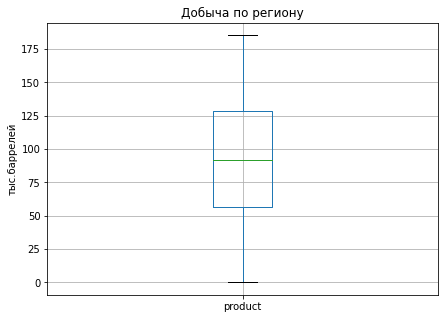

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Матрица корреляции
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000


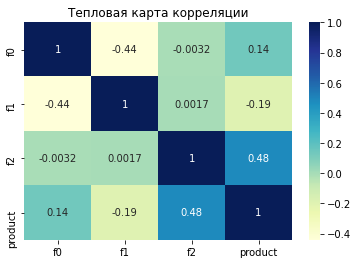

Гистограммы распределения признаков


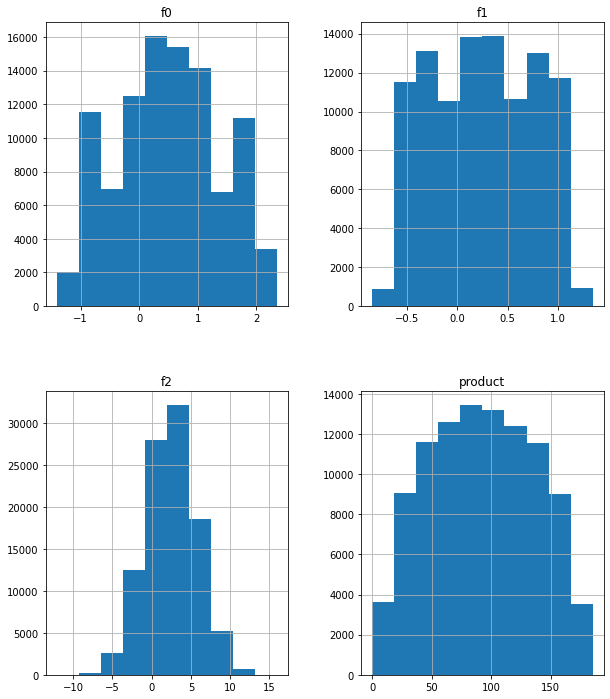

In [4]:
data_exam(r0) #Изучаем информацию по региону r0.

Вывод:
  - Дубликатов нет
  - Пропусков нет
  - Медианные и средние значения параметров приблизительно одинаковые
  - В среднем в регионе добывается 92,5 тыс бареллей, максимум 185 тыс
  - На фоне очень слабой корреляции между признаками f2 и product имеют слабую положительную 0.48 корреляцию, f1 и f0 отрицательную слабую корреляцию -0.44
  - Визуально данные имеют нормальное распределение с выбросами fo и f1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Наличие дубликатов: 0

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408



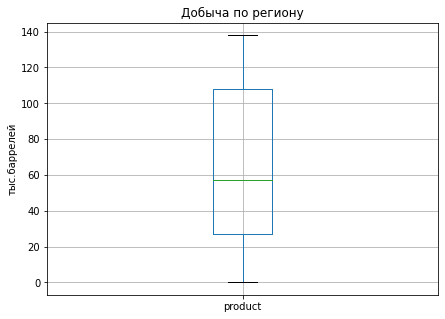

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Матрица корреляции
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000


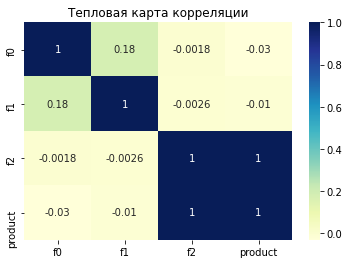

Гистограммы распределения признаков


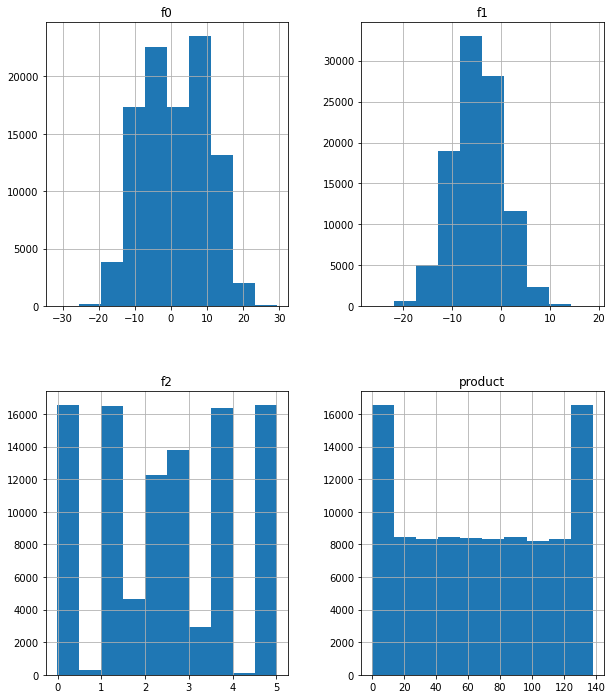

In [5]:
data_exam(r1) #Изучаем информацию по региону r1.

  Вывод:
  - Дубликатов нет
  - Пропусков нет
  - Медианные и средние значения параметров f0,f1,f2 приблизительно одинаковые, что говорит о нормальном распределении данных, признак product скошен вправо, это наглядно видно на барплоте.
  - В среднем в регионе добывается 68,83 тыс бареллей, максимум 138 тыс
  - На фоне очень слабой корреляции между признаками,признаки f2 и product сильно взаимосвязаны и имеют корреляцию 1.
  - Визуально данные f0 b f1 имеют нормальное распределение с некими пиками fo, f2 и product не нормально распределены, глядя на product можно сказать, что число скважин с добычей от 15 до 120 тысяч бареллей приблизительно одинаково в пределах чуть больше 8 тысяч, так же видно, что в регионе больше 16 тысяч скважин с максимальной добычей около 140 тыс., и такое число скважин со слаюой добычей до 15 тыс.  


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Наличие дубликатов: 0

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838



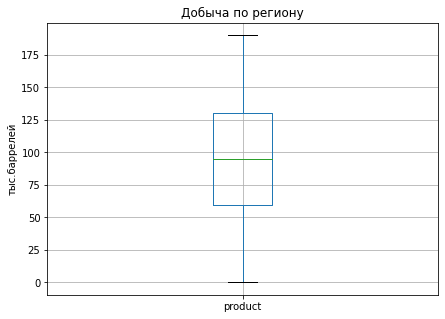

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Матрица корреляции
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


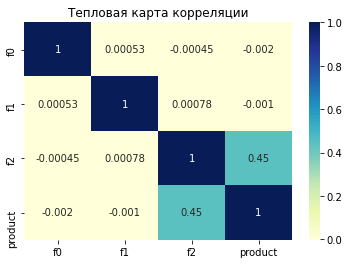

Гистограммы распределения признаков


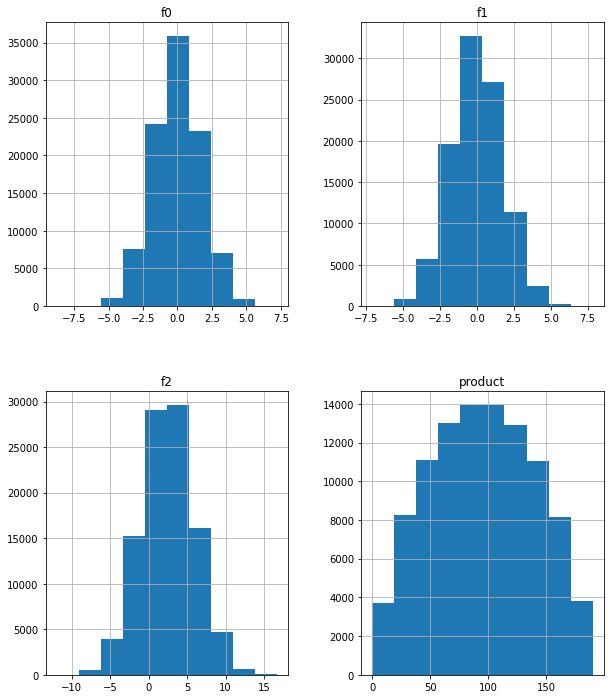

In [6]:
data_exam(r2) #Изучаем информацию по региону r2.

 Вывод:
  - Дубликатов нет
  - Пропусков нет
  - Медианные и средние значения параметров приблизительно одинаковые, f1 и f2 близки к 0.
  - В среднем в регионе добывается 95 тыс бареллей, максимум 190 тыс
  - Взаимосвязи между признаками нет, за исключением того, что признаки f2 и product слабо взаимовязаны с корреляцией 0.45.
  - Визуально данные распределены нормально

## Обучение и проверка модели

Создал процедуру для разбиения датафрейма на выбоки, приведения features к одному масштабу, обучению модели линейной регрессии, предсказанию модели, вычислению метрики RMSE и вычислению среднего предсказанного обьема нефти добываемой в регионе.

In [7]:
def prepare_checking(region):
    features = region.drop(["product","id"], axis=1) # извлекаем признаки 
    target = region["product"] # извлекаем целевой признак

    features_train, features_valid, target_train, target_valid = \
            train_test_split(features,target,train_size=0.75,random_state=12345)

    display("Размер обучающей выборки")
    display(features_train.shape)
    display(target_train.shape)
    display("Размер валидационной выборки")
    display(features_valid.shape)
    display(target_valid.shape)
    
    #Приведем чтсленные признаки к одному масштабу
    numeric = ['f0','f1','f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    model = LinearRegression().fit(features_train, target_train)#Обучаем модель
    predictions_valid = model.predict(features_valid)#Предсказываем 
    predictions = pd.Series(predictions_valid) #предсказания сохраняем в Series
    result = mean_squared_error(target_valid, predictions_valid)**0.5
    print("RMSE модели линейной регрессии на валидационной выборке:", result)
    mean_prod = sum(predictions)/len(predictions)
    print("средний запас предсказанного сырья :", mean_prod)
    
    return(predictions, target_valid.reset_index(drop=True), result)

**РЕГИОН 0**

In [8]:
predictions_0, validation_0, rmse_0 = prepare_checking(r0) #вызываем процедуру и сохраняем основные метрики

'Размер обучающей выборки'

(75000, 3)

(75000,)

'Размер валидационной выборки'

(25000, 3)

(25000,)

RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813
средний запас предсказанного сырья : 92.59256778438008


**РЕГИОН 1**

In [9]:
predictions_1, validation_1, rmse_1 = prepare_checking(r1) #вызываем процедуру и сохраняем основные метрики

'Размер обучающей выборки'

(75000, 3)

(75000,)

'Размер валидационной выборки'

(25000, 3)

(25000,)

RMSE модели линейной регрессии на валидационной выборке: 0.893099286775617
средний запас предсказанного сырья : 68.7285468954458


**РЕГИОН 2**

In [10]:
predictions_2, validation_2, rmse_2 = prepare_checking(r2) #вызываем процедуру и сохраняем основные метрики

'Размер обучающей выборки'

(75000, 3)

(75000,)

'Размер валидационной выборки'

(25000, 3)

(25000,)

RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434
средний запас предсказанного сырья : 94.96504596800506


Вывод:
-  во каждому региону разбили исходный массив данных на выборки обучающую 75% и валидационную(тестовую)25%
-  после масштабирования features обучили и сделали предсказания на модели линейной регресии, массив предсказаний обьема добычи нефти по каждой скважине и каждому региону сохранили в series
- оценили средний обьем запасов по каждому региону, получилось что наибольший средний по скважине обьем сырья  
        - в регионе 2 - 94.97 тыс.барр. 
        - в регионе 0 - 92.59 тыс.барр.
        - в регионе 1 - 68.73 тыс.барр.
- RMSE (квадратный корень из средней квадратичной ошибки) измеряет оклонение прогнозных значений от фактических значений в модели линейной регрессии. Это стандартный способ измерения точности модели, чем меньше значение RMSE, тем более точной считается модель и более точны ее прогнозы. 
        - в регионе 1 - 0.89 тыс.барр. 
        - в регионе 0 - 37.58 тыс.барр.
        - в регионе 2 - 40.03 тыс.барр. 
- Наиболее точно модель предсказывает обьем добываемого сырья на данных в регионе 1, при том, что средний по скважине обьем сырья  в этом регионе наименьший из всех остальных регионов.        
        

## Подготовка к расчёту прибыли

Для расчета прибыли сначала обьявил основные константы, которые будут использоваться при дальнейших расчетах.

In [11]:
budget = 10**10
income_thousand_bar= 450_000
quantity_wells = 200
print(f'Бюджет на разработку скважин: {budget/10**9} млрд.руб.')
print(f'1000 бареллей стоит: {income_thousand_bar} руб.')
print(f'Планируемое количество новых скважин: {quantity_wells} шт.')

Бюджет на разработку скважин: 10.0 млрд.руб.
1000 бареллей стоит: 450000 руб.
Планируемое количество новых скважин: 200 шт.


Посчитал сколько должна добывать каждая новая скважина, чтобы не было ни прибыли  ни убытков.

In [12]:
zero_income_point = round(budget/quantity_wells/income_thousand_bar,2)
print('Точка безубыточности для одной скважины: {0:.2f} тыс. баррелей'.format(zero_income_point))

Точка безубыточности для одной скважины: 111.11 тыс. баррелей


Наш бюджет для разработки 200 новых скважин - 10 млрд.руб.Затратами на одну скважину - 50 милн.руб.. При цене в 450 тыс.руб. за тыс.баррелей, безубыточная добыча начинается со скважин с запасом в 111,11 тыс.баррелей. По средним предсказаниям в предыдущем блоке такого объема нет ни в одном регионе (в регионе 2 - 94.97 тыс.барр., в регионе 0 - 92.59 тыс.барр., в регионе 1 - 68.73 тыс.барр.)

Создал процедуру для расчета прибыли, где сначала будет сформирован датафрейм по каждому региону с реальными запасами и предполагаемыми и, в отдельном столбце income, будет подсчитана реальная выручка от добытого обьема по каждой скважине. Потом из этого датафрейма на основе предсказанных запасов будут отобраны 200 наиболее продуктивных скважин, посчитан реальный обьем добычи с этих скважин, реальная полученная выручка и от этого обьема посчитана прибыль. 

In [13]:
def profit(validation, predictions):
    reg = pd.DataFrame()
    reg['product_real'] = validation
    reg['product_predicted'] = predictions
    reg['income'] = validation * income_thousand_bar
     
    max_wells = reg.sort_values(by = 'product_predicted',ascending=False)[:quantity_wells]
    max_wells_volume = round(max_wells.product_real.sum())
    profit = round(max_wells.income.sum() - budget)/10**9
    
    print(f'Макисмальный объёма сырья выбранных скважин: {max_wells_volume} тыс.баррелей')
    print(f'Прибыль от полученного объёма сырья: {profit} млрд.руб')
    return reg
    

## Расчёт прибыли и рисков 

Для каждого региона теперь считаем прибыль, макисмальный объём сырья выбранных 200 скважин и сохраняем каждый сформированный датафрейм, тк он нам пригодиться в дальнейших расчетах.

In [14]:
reg0 = profit(validation_0, predictions_0)
reg0

Макисмальный объёма сырья выбранных скважин: 29602 тыс.баррелей
Прибыль от полученного объёма сырья: 3.320826043 млрд.руб


,product_real,product_predicted,income
0,10.038645,95.894952,4.517390e+06
1,114.551489,77.572583,5.154817e+07
2,132.603635,77.892640,5.967164e+07
3,169.072125,90.175134,7.608246e+07
4,122.325180,70.510088,5.504633e+07
...,...,...,...
24995,170.116726,103.037104,7.655253e+07
24996,93.632175,85.403255,4.213448e+07
24997,127.352259,61.509833,5.730852e+07
24998,99.782700,118.180397,4.490221e+07


In [15]:
reg1 = profit(validation_1, predictions_1)
reg1

Макисмальный объёма сырья выбранных скважин: 27589 тыс.баррелей
Прибыль от полученного объёма сырья: 2.415086697 млрд.руб


,product_real,product_predicted,income
0,80.859783,82.663314,3.638690e+07
1,53.906522,54.431786,2.425793e+07
2,30.132364,29.748760,1.355956e+07
3,53.906522,53.552133,2.425793e+07
4,0.000000,1.243856,0.000000e+00
...,...,...,...
24995,137.945408,136.869211,6.207543e+07
24996,110.992147,110.693465,4.994647e+07
24997,137.945408,137.879341,6.207543e+07
24998,84.038886,83.761966,3.781750e+07


In [16]:
reg2 = profit(validation_2, predictions_2)
reg2

Макисмальный объёма сырья выбранных скважин: 28245 тыс.баррелей
Прибыль от полученного объёма сырья: 2.710349964 млрд.руб


,product_real,product_predicted,income
0,61.212375,93.599633,2.754557e+07
1,41.850118,75.105159,1.883255e+07
2,57.776581,90.066809,2.599946e+07
3,100.053761,105.162375,4.502419e+07
4,109.897122,115.303310,4.945370e+07
...,...,...,...
24995,28.492402,78.765887,1.282158e+07
24996,21.431303,95.603394,9.644086e+06
24997,125.487229,99.407281,5.646925e+07
24998,99.422903,77.779912,4.474031e+07


По расчетам в каждой регионе прибыль составляет:
  - регион0 3.32 млрд.руб. при обьеме добычи 29602 тыс.барр.
  - регион2 2.71 млрд.руб. при обьеме добычи 28245 тыс.барр.
  - регион1 2.42 млрд.руб. при обьеме добычи 27589 тыс.барр.

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. 
Создал процедуру, которая будет 1000 раз в случайном порядке из комбинированных датафреймов,которые мы сохранили на предыдущем этапе, где у нас есть реальные обьемы добычи и предсказанные обьемы добычи и доход по каждой скважине, выбирать выборки размером 500 скважин. Из этих 500 каждый раз будем выбирать 200 наиболее продуктивных скважин и считать для них прибыль. Из значений прибыли создадим массив revenue, посмотрим его распределение, есть ли отрицательные значения, что будет означать убытки, и долю этих убытков в доверительном интервале 95%(То есть отбрасываем 5% значений, а для остальных ищем максимум)

In [17]:
sample_quantity = 1000
sample_size = 500

In [18]:
def revenue(df):
    state = np.random.RandomState(12345)
    revenue = []
    for i in range(sample_quantity): 
        data = df.sample(n=sample_size, random_state=state, replace=True)
        max_pred = data.sort_values(by='product_predicted', ascending=False)[:quantity_wells]
        profit = (max_pred['income'].sum() - budget)/10**9
        revenue.append(profit)
    max_wells_volume = round(max_pred.product_real.sum())
    revenue = pd.Series(revenue)
    mean = revenue.mean()
    lower = revenue.quantile(0.025)
    upper = revenue.quantile(0.975)
    losses =  revenue[revenue < 0]
   
   
    print('Максимальный обьем запасов по скважинам: {:.0f} тыс.барр.'.format(max_wells_volume))
    print('Cредний обьем запасов по скважине: {:.0f} тыс.барр.'.format(max_wells_volume/quantity_wells))
    print('Средняя прибыль со скважины: {:.3f} млрд.руб.'.format(revenue.sum()/len(revenue)))
    print('2,5%-квантиль: {:.6f} млрд.руб.'.format(lower))
    print('97,5%-квантиль: {:.6f} млрд.руб.'.format(upper))
    print('Количество убыточных экспериментов:',losses.count())
    print('Вероятность убытков: {:.2%}'.format(losses.count()/len(revenue)))
    print()
    print(revenue.describe())     

In [19]:
revenue(reg0)

Максимальный обьем запасов по скважинам: 22710 тыс.барр.
Cредний обьем запасов по скважине: 114 тыс.барр.
Средняя прибыль со скважины: 0.396 млрд.руб.
2,5%-квантиль: -0.111216 млрд.руб.
97,5%-квантиль: 0.909767 млрд.руб.
Количество убыточных экспериментов: 69
Вероятность убытков: 6.90%

count    1000.000000
mean        0.396165
std         0.266614
min        -0.369567
25%         0.213920
50%         0.395009
75%         0.579300
max         1.349267
dtype: float64


In [20]:
revenue(reg1)

Максимальный обьем запасов по скважинам: 22499 тыс.барр.
Cредний обьем запасов по скважине: 112 тыс.барр.
Средняя прибыль со скважины: 0.456 млрд.руб.
2,5%-квантиль: 0.033821 млрд.руб.
97,5%-квантиль: 0.852289 млрд.руб.
Количество убыточных экспериментов: 15
Вероятность убытков: 1.50%

count    1000.000000
mean        0.456045
std         0.207847
min        -0.192268
25%         0.325048
50%         0.457036
75%         0.598976
max         1.154047
dtype: float64


In [21]:
revenue(reg2)

Максимальный обьем запасов по скважинам: 22669 тыс.барр.
Cредний обьем запасов по скважине: 113 тыс.барр.
Средняя прибыль со скважины: 0.404 млрд.руб.
2,5%-квантиль: -0.163350 млрд.руб.
97,5%-квантиль: 0.950360 млрд.руб.
Количество убыточных экспериментов: 76
Вероятность убытков: 7.60%

count    1000.000000
mean        0.404404
std         0.273276
min        -0.417857
25%         0.228147
50%         0.407206
75%         0.601945
max         1.330593
dtype: float64


Вывод:
    
    После применения техники bootstrep вероятность убытков по регионам выглядит следующим оьразом:
        регион2 - 7.6 %
        регион0 - 6.9 %
        регион1 - 1.5 % НАИЛУЧШИЙ ПОКАЗАТЕЛЬ
        
    средняя прибыль:
        регион1 - 0.456045 млрд.руб. НАИЛУЧШИЙ ПОКАЗАТЕЛЬ
        регион2 - 0.404404 млрд.руб.
        регион0 - 0.396165 млрд.руб.
    
    с вероятностью 95% мы не получим убытков в регионе1, так как нижний(2,5%) и верхний (97,5%) квантили положительные,
    в отличие от реиона0 и региона2, где нижние квантили отрицательные.  
    

## Общий вывод:

Для решения поставленной задачи по определению наиболее перспективного региона для разработки новых 200 нефтяных скважин сделано:

1. Проведен исследовательский анализ данных, проверены датасеты на наличие пропусков, дупликатов, корреляции данных, а также исследовано распределение признаков, которые, в общем, распределены нормально.В целом на фоне очень слабой корреляции между признаками по регионам 0 и 2, выделяются признаки f2 и product в регионе 1, которые сильно взаимосвязаны и имеют корреляцию 1.
Для региона1, глядя на product можно сказать, что число скважин с добычей от 15 до 120 тысяч бареллей приблизительно одинаково в пределах чуть больше 8 тысяч, так же видно, что в регионе больше 16 тысяч скважин с максимальной добычей около 140 тыс., что может говорить о потенциале региона, и такое же число скважин со слабой добычей до 15 тыс.

2. Использовали модель линейной регресии, для предсказания объемов нефти в скважинах.
во каждому региону разбили исходный массив данных на выборки обучающую 75% и валидационную(тестовую)25%
после масштабирования features обучили и сделали предсказания на модели линейной регресии, массив предсказаний обьема добычи нефти по каждой скважине и каждому региону сохранили в series
оценили средний обьем запасов по каждому региону, получилось что наибольший средний по скважине обьем сырья
  - в регионе 2 - 94.97 тыс.барр. 
  - в регионе 0 - 92.59 тыс.барр.
  - в регионе 1 - 68.73 тыс.барр.
RMSE (квадратный корень из средней квадратичной ошибки)
  - в регионе 1 - 0.89 тыс.барр. 
  - в регионе 0 - 37.58 тыс.барр.
  - в регионе 2 - 40.03 тыс.барр. 
Получилось что наиболее точно модель предсказывает обьем добываемого сырья на данных в регионе 1, при том, что средний по скважине обьем сырья в этом регионе наименьший из всех остальных регионов.

3. Определена точка безубыточности для одной скважины: 111.11 тыс. баррелей

4. На основе предсказанных моделью запасов для каждого региона были отобраны 200 наиболее продуктивных скважин, посчитан реальный обьем добычи с этих скважин, реальная полученная выручка и от этого обьема посчитана прибыль.
По расчетам в каждой регионе прибыль составила:
  - регион0 3.32 млрд.руб. при обьеме добычи 29602 тыс.барр.
  - регион2 2.71 млрд.руб. при обьеме добычи 28245 тыс.барр.
  - регион1 2.42 млрд.руб. при обьеме добычи 27589 тыс.барр.
  
5. Была выполнена процедура bootstrep и определен 95% доверительный интервал для среднего объема нефти в скважинах. 
Получилось, что в среднем, по всем регионам скважины дают обьем достаточный для безубытка (регион0 = 114 тыс.барр., регион1 = 112 тыс.барр.(точка безубыточности), регион2 = 113 тыс.барр.). 
Наиболее перспективным для разработки на мой взгляд выглядит регион1, так как риски убытков в этом регионе наименьшие (1,5%), а средняя прибыль наибольшая (0.456045 млрд.руб).